In [125]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [126]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               737 non-null    object 
 1   SeasonNumber       737 non-null    int64  
 2   SeasonVersion      737 non-null    int64  
 3   Player             737 non-null    object 
 4   MatchId            737 non-null    object 
 5   Map                737 non-null    object 
 6   Category           737 non-null    object 
 7   Playlist           737 non-null    object 
 8   Input              737 non-null    object 
 9   Queue              737 non-null    object 
 10  PreCsr             737 non-null    int64  
 11  PostCsr            737 non-null    int64  
 12  Rank               737 non-null    int64  
 13  WasAtStart         737 non-null    int64  
 14  WasAtEnd           737 non-null    int64  
 15  WasInProgressJoin  737 non-null    int64  
 16  Mmr                2 non-n

In [127]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               496 non-null    int64         
 1   Date                496 non-null    datetime64[ns]
 2   SeasonNumber        496 non-null    int64         
 3   SeasonVersion       496 non-null    int64         
 4   Map                 496 non-null    object        
 5   Category            496 non-null    object        
 6   Rank                496 non-null    int64         
 7   Outcome             496 non-null    int64         
 8   Accuracy            496 non-null    float64       
 9   DamageDone          496 non-null    int64         
 10  DamageTaken         496 non-null    int64         
 11  ShotsFired          496 non-null    int64         
 12  ShotsLanded         496 non-null    int64         
 13  ShotsMissed         496 non-null    int64         

In [128]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,496.0,437.322581,171.726341,140.000000,289.750000,436.500000,582.250000,735.000000
SeasonNumber,496.0,5.104839,0.306655,5.000000,5.000000,5.000000,5.000000,6.000000
SeasonVersion,496.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Rank,496.0,3.965726,2.153886,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,496.0,0.540323,0.498875,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,496.0,51.315746,5.408854,24.390000,48.240000,51.455000,54.452500,80.560000
DamageDone,496.0,5195.294355,1805.106847,347.000000,3928.000000,4936.000000,6412.250000,12673.000000
DamageTaken,496.0,4423.441532,1491.883202,276.000000,3448.750000,4216.500000,5343.750000,9962.000000
ShotsFired,496.0,235.917339,78.039586,16.000000,182.750000,227.000000,289.500000,517.000000
ShotsLanded,496.0,120.854839,41.489722,4.000000,94.000000,115.000000,148.000000,286.000000


In [129]:
# dfr.tail()
# round(dfr.sort_values('LifetimeAcc', ascending=False),2)

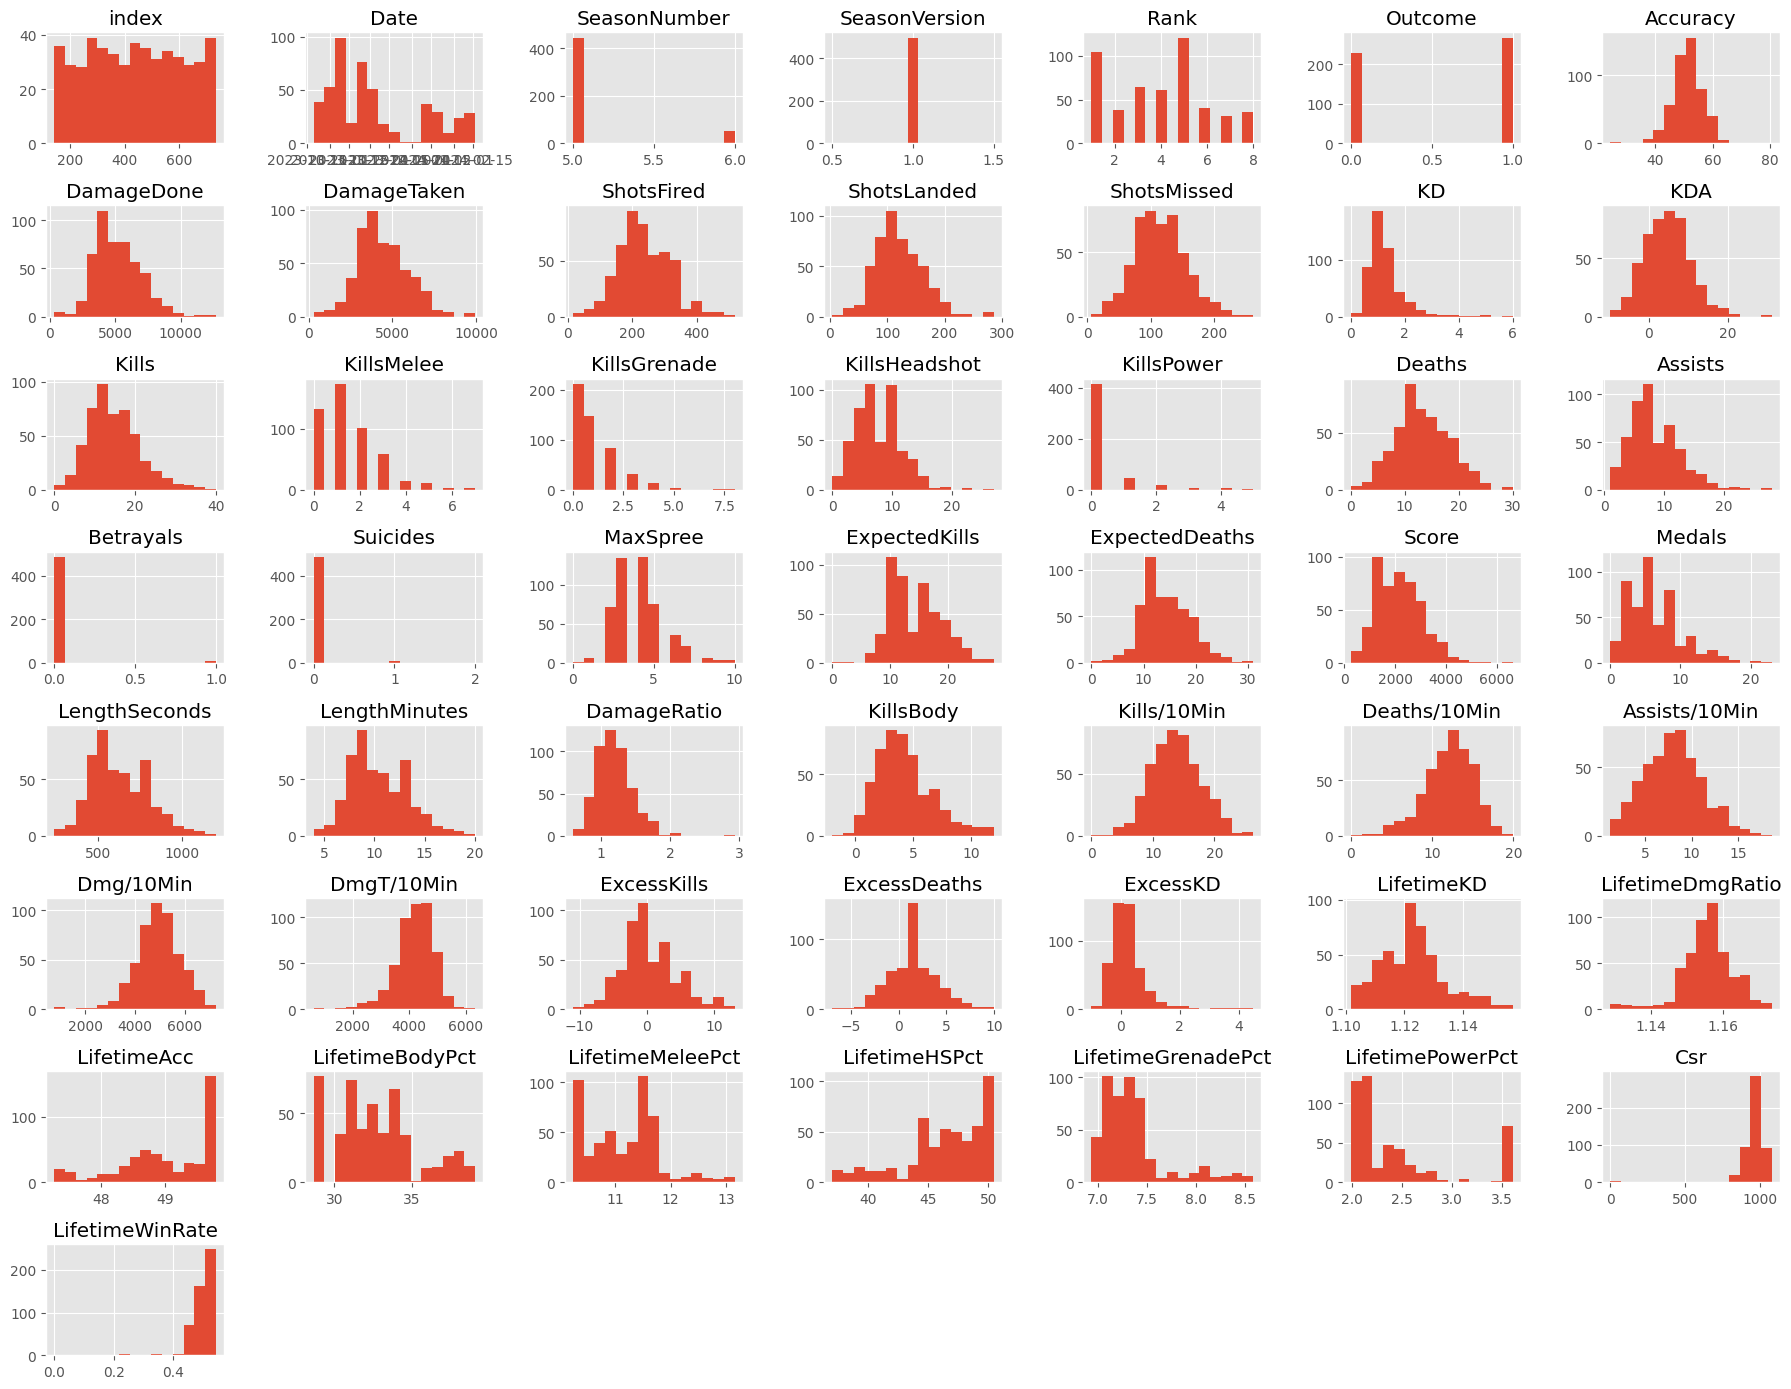

In [130]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

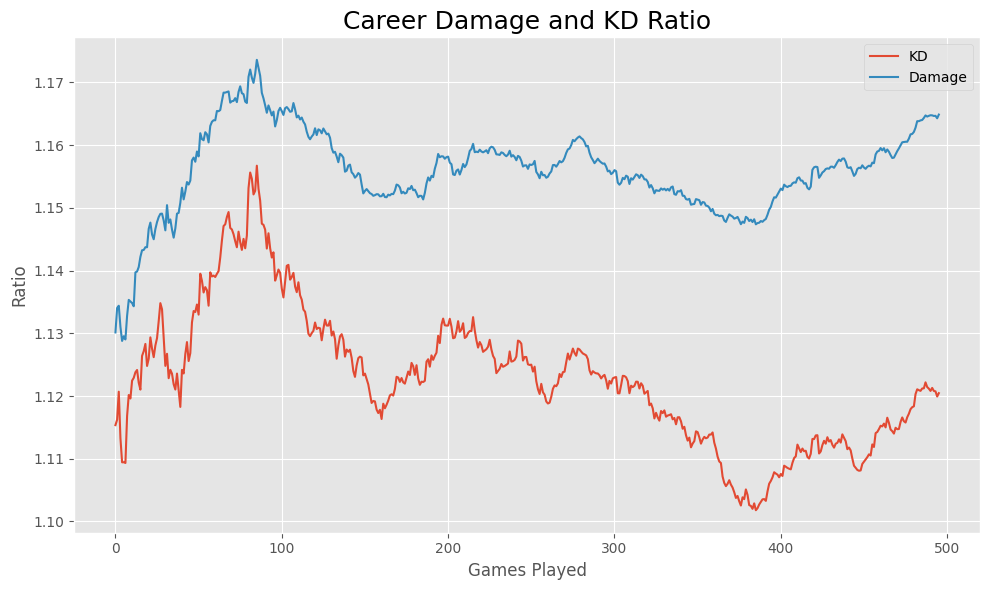

In [149]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

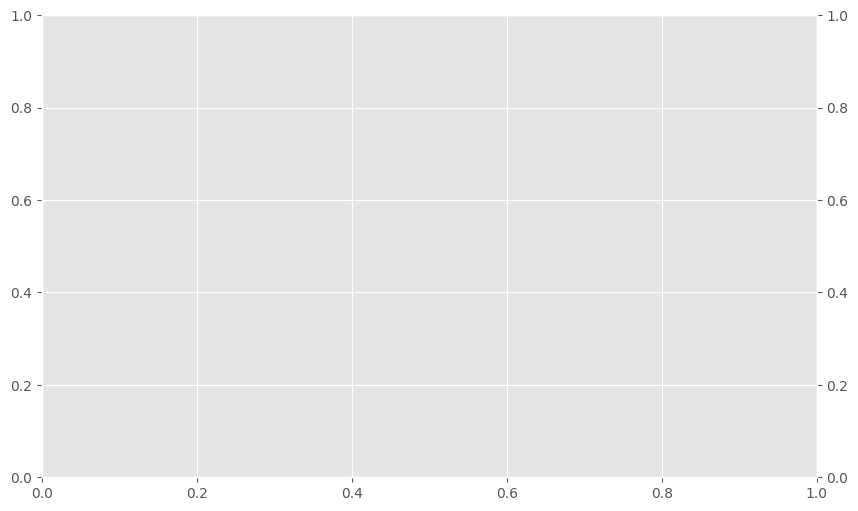

In [132]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

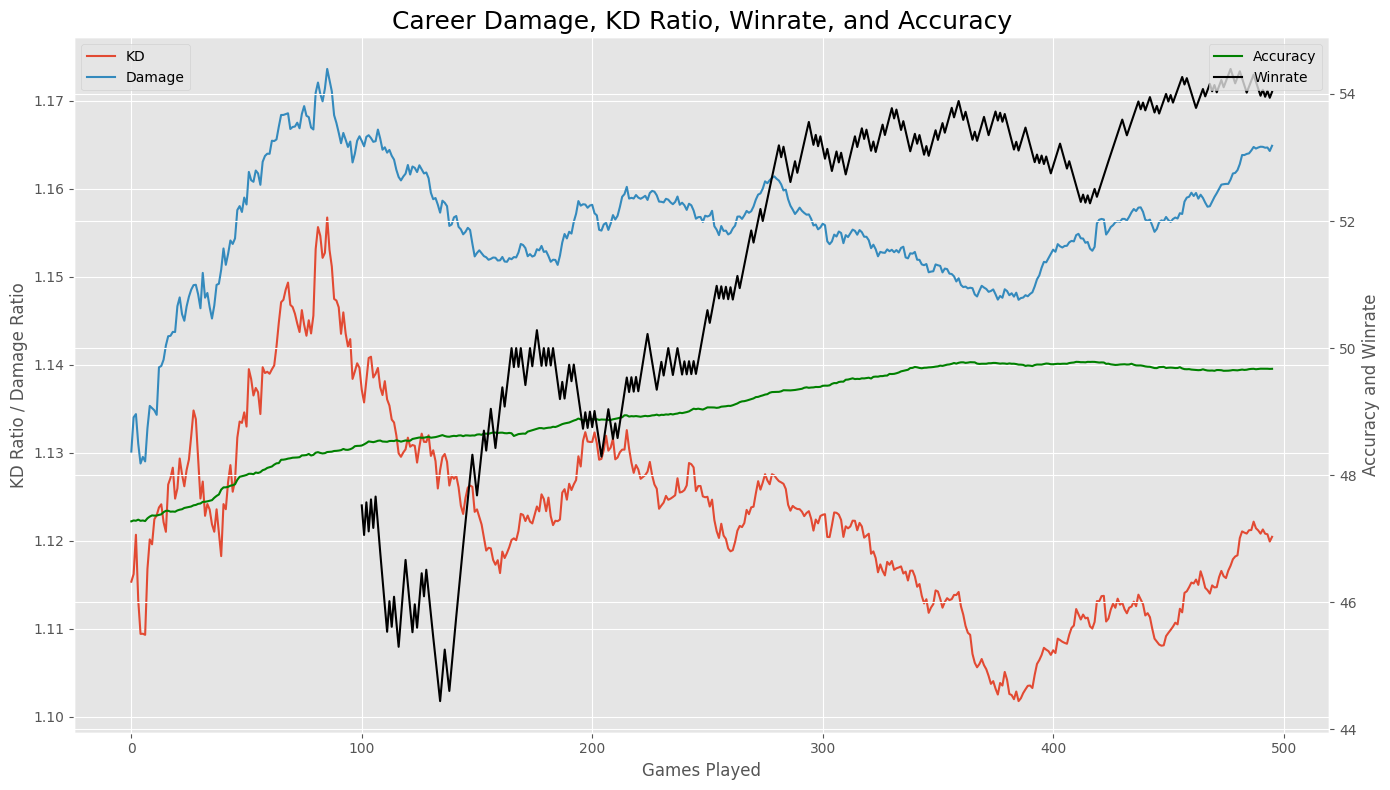

In [150]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

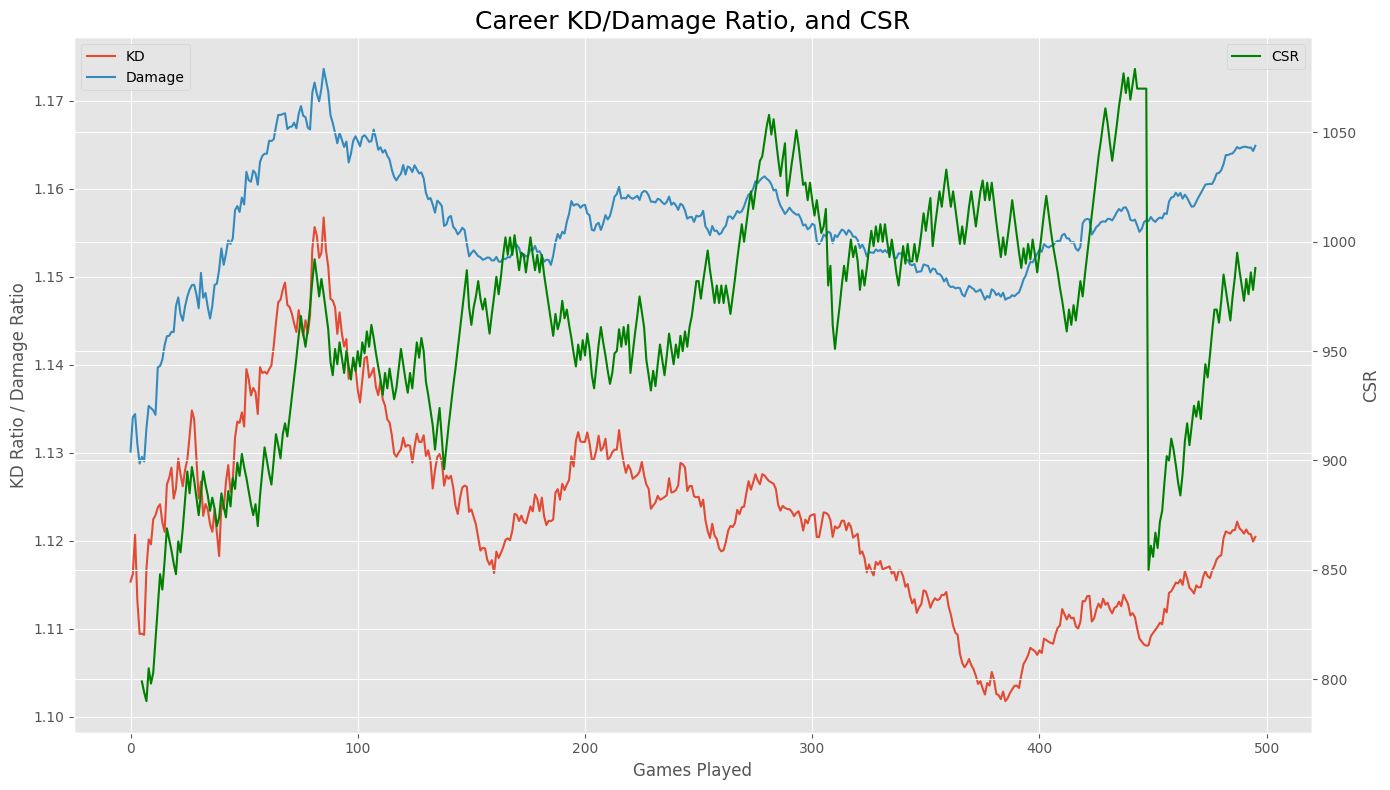

In [151]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

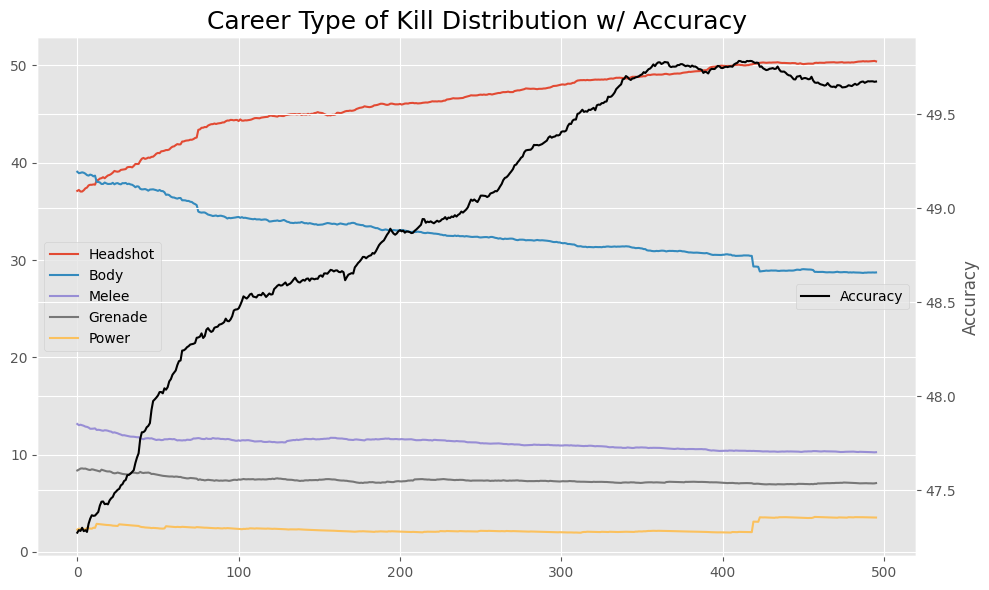

In [153]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

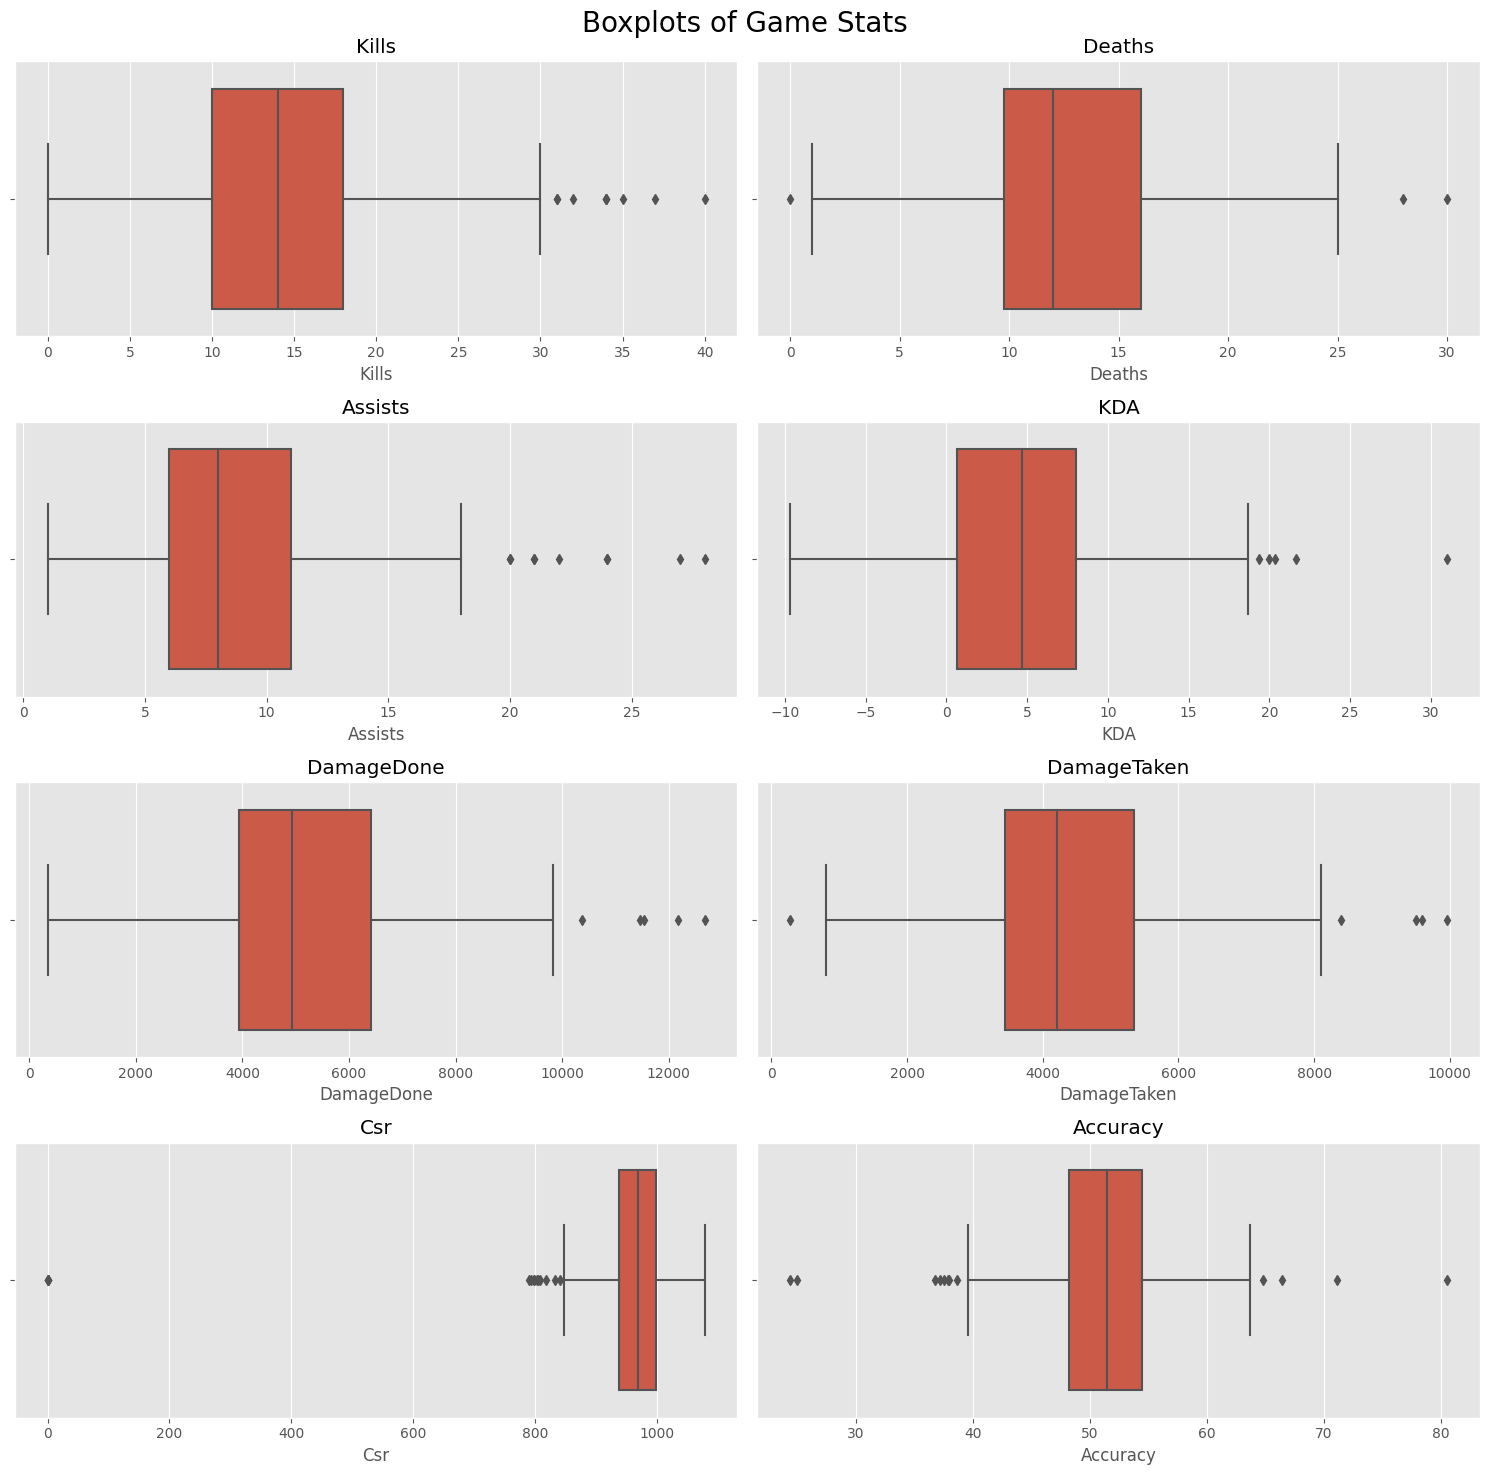

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [137]:
mod = 5

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.06
Accuracy: 49.36
Damage Ratio: 1.18
Win-Loss: 3-2
Max CSR: 988


In [138]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.78
Average Deaths: 12.06
Average Assists: 8.0
Average Accuracy: 51.23
Average Damage Done: 5195
Average Damage Taken: 4423
Damage Ratio: 1.17
Win-Loss: 268-228
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.26
Average Deaths: 10.8
Average Assists: 8.46
Average Accuracy: 51.37
Average Damage Done: 5030
Average Damage Taken: 4083
Damage Ratio: 1.23
Wins: 268
----------------------------
Losses
Overall KD: 0.98
Average Kills: 13.21
Average Deaths: 13.53
Average Assists: 7.47
Average Accuracy: 51.07
Average Damage Done: 5389
Average Damage Taken: 4824
Damage Ratio: 1.12
Losses: 228


In [139]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 104
Games Ranked 5: 121
MVP %: 45.36


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [140]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [141]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >1 SS: " ,gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1].sort_index(ascending=True).sort_values(ascending=False))


Records with >1 SS:  33
Scorigami
15-8-7      3
7-12-7      3
6-11-8      3
16-11-8     2
8-11-5      2
7-8-7       2
7-12-4      2
7-11-6      2
24-19-6     2
21-18-9     2
20-12-6     2
19-18-10    2
17-17-3     2
17-16-11    2
17-15-9     2
17-14-5     2
10-10-3     2
10-5-7      2
15-13-8     2
15-11-8     2
15-11-10    2
15-10-14    2
14-14-7     2
14-11-8     2
14-10-11    2
13-14-10    2
13-11-9     2
12-10-6     2
11-8-7      2
11-12-7     2
10-7-5      2
10-7-1      2
9-11-3      2
dtype: int64


In [142]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1016.37,118,19.67,23.79
Strongholds,913.38,77,17.68,15.52
Oddball,863.00,73,16.70,14.72
King of the Hill,752.27,69,14.56,13.91
CTF 3 Captures,726.28,66,14.06,13.31
Extraction,611.85,70,11.84,14.11
CTF 5 Captures,283.10,23,5.48,4.64


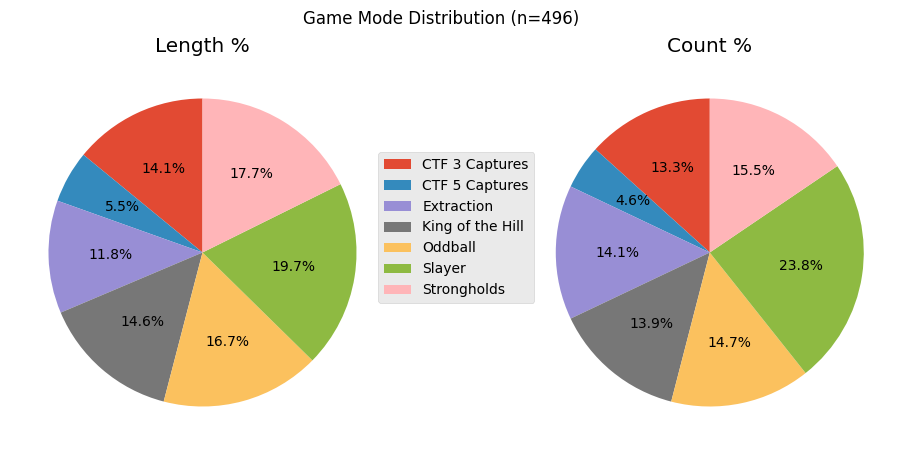

In [143]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [144]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      35         7.47     0.40    7.06     8.67
King of the Hill Recharge      34         6.58     0.53    6.85     7.64
Oddball          Streets       28         5.64     0.54    5.65     6.55
Slayer           Solitude      36         5.29     0.58    7.26     6.14
                 Aquarius      36         5.13     0.58    7.26     5.96
Extraction       Streets       33         4.74     0.61    6.65     5.50
CTF 5 Captures   Aquarius      23         4.72     0.43    4.64     5.48
Oddball          Recharge      24         4.62     0.58    4.84     5.36
CTF 3 Captures   Empyrean      25         4.61     0.44    5.04     5.35
                 Argyle        22         4.22     0.45    4.44     4.90
Oddball          Live Fire     21         4.13     0.62    4.23     4.80
Strongholds      Recharge      21         3.94     0.43    4.23     4.57
                 Live Fire     21         3.81     0.52    4.23     4.42
CTF 3 Captures   Forbidden     19         3.28     0.63    3.83     3.81
King of the Hill Live Fire     21         3.27     0.76    4.23     3.80
Extraction       Recharge      18         2.76     0.61    3.63     3.20
                 Live Fire     19         2.70     0.42    3.83     3.13
King of the Hill Solitude      14         2.69     0.50    2.82     3.12
Slayer           Streets       18         2.38     0.72    3.63     2.76
                 Live Fire     16         2.32     0.44    3.23     2.69
                 Recharge      12         1.83     0.58    2.42     2.12

In [145]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     21    303     276      143      100779   
Slayer           Streets       18    165     163      119       67409   
CTF 3 Captures   Forbidden     19    272     200      129       95507   
Oddball          Live Fire     21    326     324      220      124724   
Extraction       Recharge      18    230     193      143       80159   
                 Streets       33    453     351      253      147191   
Slayer           Recharge      12    112     114       82       48697   
                 Solitude      36    386     389      239      150663   
Oddball          Recharge      24    386     322      239      140527   
Slayer           Aquarius      36    382     360      228      148586   
Oddball          Streets       28    492     444      305      172665   
King of the Hill Recharge      34    601     523      413      216227   
Strongholds      Live Fire     21    330     271      138      111917   
King of the Hill Solitude      14    270     204      140       85583   
CTF 3 Captures   Argyle        22    319     275      152      115264   
                 Empyrean      25    364     339      195      131079   
Slayer           Live Fire     16    165     160       87       60705   
CTF 5 Captures   Aquarius      23    460     333      220      151198   
Strongholds      Recharge      21    306     298      200      114450   
Extraction       Live Fire     19    230     216      125       82363   
Strongholds      Solitude      35    679     585      403      231173   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
King of the Hill Live Fire        90562     0.76         196.07     53.63   
Slayer           Streets          58348     0.72         142.63     48.44   
CTF 3 Captures   Forbidden        73180     0.63         196.58     51.70   
Oddball          Live Fire       105508     0.62         247.52     51.54   
Extraction       Recharge         66596     0.61         165.43     51.43   
                 Streets         118482     0.61         284.25     54.27   
Slayer           Recharge         44551     0.58         109.67     46.74   
                 Solitude        138263     0.58         317.13     49.67   
Oddball          Recharge        114858     0.58         277.12     49.17   
Slayer           Aquarius        131333     0.58         307.62     50.83   
Oddball          Streets         149097     0.54         338.37     53.76   
King of the Hill Recharge        179900     0.53         394.73     50.22   
Strongholds      Live Fire        98213     0.52         228.87     52.94   
King of the Hill Solitude         70552     0.50         161.47     51.55   
CTF 3 Captures   Argyle           95482     0.45         253.40     49.19   
                 Empyrean        116504     0.44         276.30     51.03   
Slayer           Live Fire        58232     0.44         139.32     48.54   
CTF 5 Captures   Aquarius        117058     0.43         283.10     51.62   
Strongholds      Recharge         99050     0.43         236.13     48.14   
Extraction       Live Fire        72351     0.42         162.17     55.24   
Strongholds      Solitude        195907     0.40         448.38     52.81   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
King of the Hill Live Fire  1.10         1.11    365.14       37.02   
Slayer           Streets    1.01         1.16    413.55       55.59   
CTF 3 Captures   Forbidden  1.36         1.31    477.54      111.64   
Oddball          Live Fire  1.01         1.18    384.95       59.31   
Extraction       Recharge   1.19         1.20    415.33       70.27   
                 Streets    1.29         1.24    419.35       81.79   
Slayer  

In [146]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
Oddball,73,1204,1090,764,437916,369463,0.58,1.10,1.19,401.76,62.80,0.70
King of the Hill,69,1174,1003,696,402589,341014,0.59,1.17,1.18,401.38,61.39,0.69
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
CTF 5 Captures,23,460,333,220,151198,117058,0.43,1.38,1.29,454.05,102.52,0.66
Strongholds,77,1315,1154,741,457540,393170,0.44,1.14,1.16,396.48,55.78,0.64
Slayer,118,1210,1186,755,476060,430727,0.58,1.02,1.11,401.40,38.22,0.64
CTF 3 Captures,66,955,814,476,341850,285166,0.50,1.17,1.20,419.96,69.64,0.58


In [147]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,109,1635,1450,1077,600060,504955,0.54,1.13,1.19,413.83,65.59,0.74
Streets,79,1110,958,677,387265,325927,0.61,1.16,1.19,404.24,64.03,0.71
Solitude,85,1335,1178,782,467419,404722,0.49,1.13,1.15,396.79,53.22,0.66
Aquarius,59,842,693,448,299784,248391,0.53,1.22,1.21,432.59,74.16,0.65
Forbidden,19,272,200,129,95507,73180,0.63,1.36,1.31,477.54,111.64,0.64
Empyrean,25,364,339,195,131079,116504,0.44,1.07,1.13,386.66,42.99,0.58
Live Fire,98,1354,1247,713,480488,424866,0.56,1.09,1.13,385.32,44.60,0.57
Argyle,22,319,275,152,115264,95482,0.45,1.16,1.21,419.14,71.93,0.55


In [148]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 7.100650416978169s
